In [1]:
import numpy as np
import math
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

import os

# Findings
- Single feature:
    - "policyCode": all values are the same
    - "applicationType": 98% of data are 0, only 2% are 1
    - "homeOwnership": 89% of data have values of 0 or 1, only 11% are > 1 (group 2-5 together)
- Most numeric features are right skewed (have large outliers)
- Default rate by nitialListStatus and employmentLength does not differ much
- The correlation between numeric continuous features and label is weak, but the correlation among subset of features are very high (multi-collinearity problem?)
- People who defaulted, typically have higher loanAmnt, interestRate, installment, dti, openAcc, n1-3, n9, n14, and lower ficoRange, compared to people who have not defaulted

## Read data

In [4]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/testA.csv")

In [5]:
print("There are %d training data" % len(train))
print("There are %d testing data" % len(test))

There are 800000 training data
There are 200000 testing data


In [6]:
train.head(5)

,id,loanAmnt,term,interestRate,installment,grade,subGrade,employmentTitle,employmentLength,homeOwnership,annualIncome,verificationStatus,issueDate,isDefault,purpose,postCode,regionCode,dti,delinquency_2years,ficoRangeLow,ficoRangeHigh,openAcc,pubRec,pubRecBankruptcies,revolBal,revolUtil,totalAcc,initialListStatus,applicationType,earliesCreditLine,title,policyCode,n0,n1,n2,n3,n4,n5,n6,n7,n8,n9,n10,n11,n12,n13,n14
0,0,35000.0,5,19.52,917.97,E,E2,320.0,2 years,2,110000.0,2,2014-07-01,1,1,137.0,32,17.05,0.0,730.0,734.0,7.0,0.0,0.0,24178.0,48.9,27.0,0,0,Aug-2001,1.0,1.0,0.0,2.0,2.0,2.0,4.0,9.0,8.0,4.0,12.0,2.0,7.0,0.0,0.0,0.0,2.0
1,1,18000.0,5,18.49,461.90,D,D2,219843.0,5 years,0,46000.0,2,2012-08-01,0,0,156.0,18,27.83,0.0,700.0,704.0,13.0,0.0,0.0,15096.0,38.9,18.0,1,0,May-2002,1723.0,1.0,NaN,NaN,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN,13.0,NaN,NaN,NaN,NaN
2,2,12000.0,5,16.99,298.17,D,D3,31698.0,8 years,0,74000.0,2,2015-10-01,0,0,337.0,14,22.77,0.0,675.0,679.0,11.0,0.0,0.0,4606.0,51.8,27.0,0,0,May-2006,0.0,1.0,0.0,0.0,3.0,3.0,0.0,0.0,21.0,4.0,5.0,3.0,11.0,0.0,0.0,0.0,4.0
3,3,11000.0,3,7.26,340.96,A,A4,46854.0,10+ years,1,118000.0,1,2015-08-01,0,4,148.0,11,17.21,0.0,685.0,689.0,9.0,0.0,0.0,9948.0,52.6,28.0,1,0,May-1999,4.0,1.0,6.0,4.0,6.0,6.0,4.0,16.0,4.0,7.0,21.0,6.0,9.0,0.0,0.0,0.0,1.0
4,4,3000.0,3,12.99,101.07,C,C2,54.0,NaN,1,29000.0,2,2016-03-01,0,10,301.0,21,32.16,0.0,690.0,694.0,12.0,0.0,0.0,2942.0,32.0,27.0,0,0,Aug-1977,11.0,1.0,1.0,2.0,7.0,7.0,2.0,4.0,9.0,10.0,15.0,7.0,12.0,0.0,0.0,0.0,4.0


# EDA

- create the directories to save output pictures

In [266]:
if not os.path.exists("assets"):
    os.mkdir("assets")
    
if not os.path.exists("assets/distribution"):
    os.mkdir("assets/distribution")
    
if not os.path.exists("assets/default_rate"):
    os.mkdir("assets/default_rate")

## Check unique values
- check the variety of feature values, drop the feature if only one value occurs
- drop "policyCode" in later feature engineering part

In [56]:
unique_values = {}

for feat in train.columns:
    unique_values[feat] = len(train[feat].value_counts())

unique_values = pd.DataFrame.from_dict(unique_values, orient='index', columns=["value_cnt"])
unique_values.sort_values("value_cnt", ascending=True, inplace=True)

In [57]:
unique_values

,value_cnt
policyCode,1
term,2
applicationType,2
initialListStatus,2
isDefault,2
verificationStatus,3
n12,5
n11,5
homeOwnership,6
grade,7


In [57]:
train["term"].value_counts()

3    606902
5    193098
Name: term, dtype: int64

## Check missing values
- Most missing values (5-8%) are in behavioural features (n0-n14), employmentLength
- There are also a few missing values (<1%) in employmentTitle, postCode, dti, pubRecBankruptcies, revolUtil, title

In [15]:
missing = pd.DataFrame(train.isnull().sum().sort_values(ascending=False), columns=["missing_cnt"])
missing["missing_rate"] = missing["missing_cnt"].apply(lambda x: x / len(train))

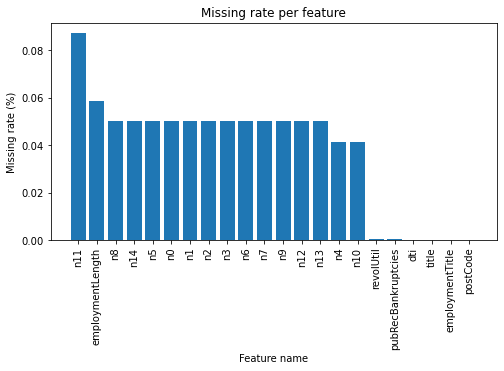

In [38]:
fig = plt.figure(figsize = (8, 4))
plt.bar(missing[missing["missing_cnt"] > 0].index,
        missing[missing["missing_cnt"] > 0]["missing_rate"])
plt.xticks(rotation = 90)
plt.title("Missing rate per feature")
plt.ylabel("Missing rate (%)")
plt.xlabel("Feature name")

plt.savefig("assets/Missing_rate_per_feature.png")
plt.show()

In [16]:
missing[missing["missing_cnt"] > 0]

,missing_cnt,missing_rate
n11,69752,0.087190
employmentLength,46799,0.058499
n8,40271,0.050339
n14,40270,0.050338
n5,40270,0.050338
n0,40270,0.050338
n1,40270,0.050338
n2,40270,0.050338
n3,40270,0.050338
n6,40270,0.050338


## Split categorical and numeric features

In [83]:
cate_feat = list(train.select_dtypes(include=['object']).columns)
num_feat = [c for c in train.columns if c not in cate_feat + ['isDefault']]

# numeric value, but are discrete (like categorical features or high dimensional ids)

numeric_discrete_feat = [c for c in unique_values[unique_values["value_cnt"] < 15].index if c != "isDefault" and c not in cate_feat] \
                        + ['id', 'employmentTitle', 'postCode', 'regionCode', 'title']

numeric_conts_feat = [c for c in num_feat if c not in numeric_discrete_feat]

In [84]:
cate_feat

['grade', 'subGrade', 'employmentLength', 'issueDate', 'earliesCreditLine']

In [85]:
numeric_discrete_feat

['policyCode',
 'term',
 'applicationType',
 'initialListStatus',
 'verificationStatus',
 'n12',
 'n11',
 'homeOwnership',
 'pubRecBankruptcies',
 'purpose',
 'id',
 'employmentTitle',
 'postCode',
 'regionCode',
 'title']

In [86]:
numeric_conts_feat

['loanAmnt',
 'interestRate',
 'installment',
 'annualIncome',
 'dti',
 'delinquency_2years',
 'ficoRangeLow',
 'ficoRangeHigh',
 'openAcc',
 'pubRec',
 'revolBal',
 'revolUtil',
 'totalAcc',
 'n0',
 'n1',
 'n2',
 'n3',
 'n4',
 'n5',
 'n6',
 'n7',
 'n8',
 'n9',
 'n10',
 'n13',
 'n14']

## Check outliers
- skewed features: loanAmnt, installment, openAcc
- outliers (the difference between 75% and max is huge): 
    - dti, delinquency_2years, pubRec, pubRecBankruptcies, revolUtil, totalAcc, n0-n14

In [10]:
train.describe()

,id,loanAmnt,term,interestRate,installment,employmentTitle,homeOwnership,annualIncome,verificationStatus,isDefault,purpose,postCode,regionCode,dti,delinquency_2years,ficoRangeLow,ficoRangeHigh,openAcc,pubRec,pubRecBankruptcies,revolBal,revolUtil,totalAcc,initialListStatus,applicationType,title,policyCode,n0,n1,n2,n3,n4,n5,n6,n7,n8,n9,n10,n11,n12,n13,n14
count,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,799999.000000,800000.000000,8.000000e+05,800000.000000,800000.000000,800000.000000,799999.000000,800000.000000,799761.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,799595.000000,8.000000e+05,799469.000000,800000.000000,800000.000000,800000.000000,799999.000000,800000.0,759730.000000,759730.000000,759730.000000,759730.000000,766761.000000,759730.000000,759730.000000,759730.000000,759729.000000,759730.000000,766761.000000,730248.000000,759730.000000,759730.000000,759730.000000
mean,399999.500000,14416.818875,3.482745,13.238391,437.947723,72005.351714,0.614213,7.613391e+04,1.009683,0.199513,1.745982,258.535648,16.385758,18.284557,0.318239,696.204081,700.204226,11.598020,0.214915,0.134163,1.622871e+04,51.790734,24.998861,0.416953,0.019267,1754.113589,1.0,0.511932,3.642330,5.642648,5.642648,4.735641,8.107937,8.575994,8.282953,14.622488,5.592345,11.643896,0.000815,0.003384,0.089366,2.178606
std,230940.252013,8716.086178,0.855832,4.765757,261.460393,106585.640204,0.675749,6.894751e+04,0.782716,0.399634,2.367453,200.037446,11.036679,11.150155,0.880325,31.865995,31.866674,5.475286,0.606467,0.377471,2.245802e+04,24.516126,11.999201,0.493055,0.137464,7941.474040,0.0,1.333266,2.246825,3.302810,3.302810,2.949969,4.799210,7.400536,4.561689,8.124610,3.216184,5.484104,0.030075,0.062041,0.509069,1.844377
min,0.000000,500.000000,3.000000,5.310000,15.690000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,630.000000,634.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,2.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,199999.750000,8000.000000,3.000000,9.750000,248.450000,427.000000,0.000000,4.560000e+04,0.000000,0.000000,0.000000,103.000000,8.000000,11.790000,0.000000,670.000000,674.000000,8.000000,0.000000,0.000000,5.944000e+03,33.400000,16.000000,0.000000,0.000000,0.000000,1.0,0.000000,2.000000,3.000000,3.000000,3.000000,5.000000,4.000000,5.000000,9.000000,3.000000,8.000000,0.000000,0.000000,0.000000,1.000000
50%,399999.500000,12000.000000,3.000000,12.740000,375.135000,7755.000000,1.000000,6.500000e+04,1.000000,0.000000,0.000000,203.000000,14.000000,17.610000,0.000000,690.000000,694.000000,11.000000,0.000000,0.000000,1.113200e+04,52.100000,23.000000,0.000000,0.000000,1.000000,1.0,0.000000,3.000000,5.000000,5.000000,4.000000,7.000000,7.000000,7.000000,13.000000,5.000000,11.000000,0.000000,0.000000,0.000000,2.000000
75%,599999.250000,20000.000000,3.000000,15.990000,580.710000,117663.500000,1.000000,9.000000e+04,2.000000,0.000000,4.000000,395.000000,22.000000,24.060000,0.000000,710.000000,714.000000,14.000000,0.000000,0.000000,1.973400e+04,70.700000,32.000000,1.000000,0.000000,5.000000,1.0,0.000000,5.000000,7.000000,7.000000,6.000000,11.000000,11.000000,10.000000,19.000000,7.000000,14.000000,0.000000,0.000000,0.000000,3.000000
max,799999.000000,40000.000000,5.000000,30.990000,1715.420000,378351.000000,5.000000,1.099920e+07,2.000000,1.000000,13.000000,940.000000,50.000000,999.000000,39.000000,845.000000,850.000000,86.000000,86.000000,12.000000,2.904836e+06,892.300000,162.000000,1.000000,1.000000,61680.000000,1.0,51.000000,33.000000,63.000000,63.000000,49.000000,70.000000,132.000000,79.000000,128.000000,45.000000,82.000000,4.000000,4.000000,39.000000,30.000000


In [52]:
def boxplot(df, col_list, width=12, height=6, save_path=""):
    num_rows = len(col_list)
    num_cols = 4

    plt.figure(figsize=(width, height))
    
    for idx in range(num_rows):
        plt.subplot(math.ceil(num_rows / num_cols), num_cols, idx + 1)
        sns.boxplot(df[col_list[idx]])
    
    if save_path:
        plt.savefig(save_path)

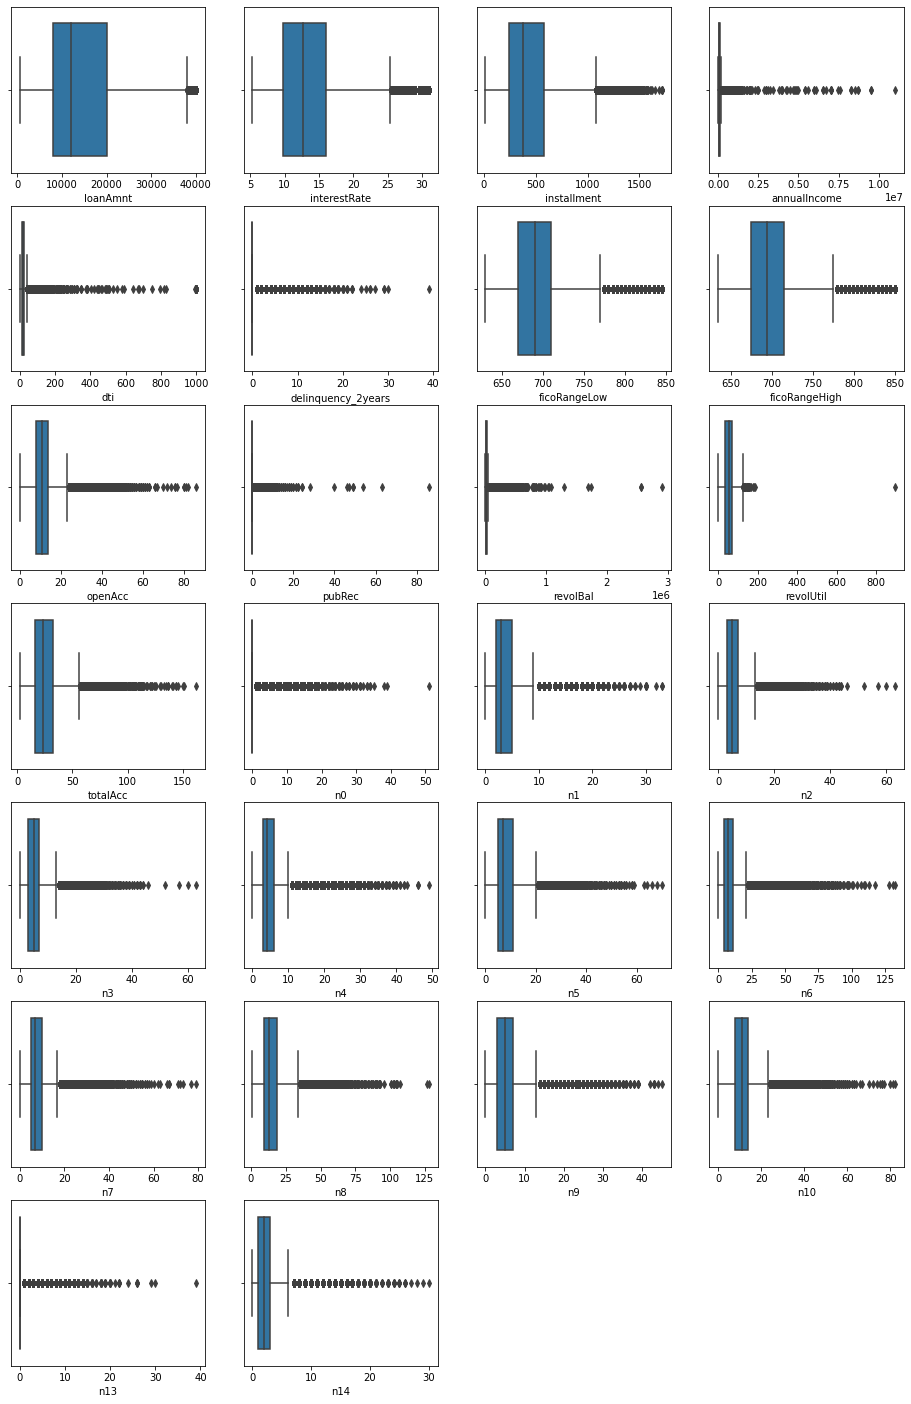

In [81]:
boxplot(train, numeric_conts_feat, width=16, height=25, save_path="assets/boxplot.png")

## Check feature distribution
- categorical (str or date)
    - grade, subGrade, employmentLength, issueDate, earliesCreditLine
- numeric: 
    - discrete: 
        - categorical (int): term, verificationStatus, purpose, homeOwnership, initialListStatus, applicationType
        - low dimension: n11, n12, pubRecBankruptcies
        - high dimensional: id, employmentTitle, postCode, regionCode, title, policyCode
    - continuous
- label: isDefault

### Categorical feature distribution

In [250]:
def plot_barchart(df, col_name, figsize=(5, 5), title="", save_path="", rotation=0):
    
    plt.figure(figsize=figsize)
    sns.barplot(
        df.value_counts(dropna=False).keys(),
        df.value_counts(dropna=False),
    )
    
    plt.xlabel(col_name)
    if rotation:
        plt.xticks(rotation = 90)
    plt.ylabel("count")
    
    if title:
        plt.title(title)
        
    if save_path:
        plt.savefig(save_path)
        
    plt.show()

- grade, subgrade, employmentLength

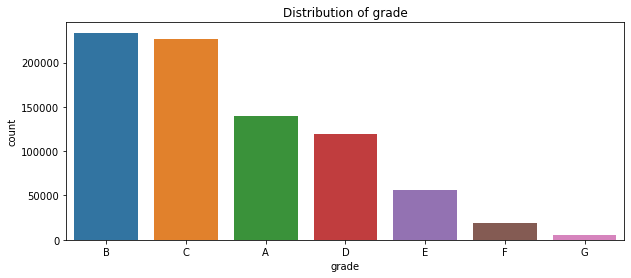

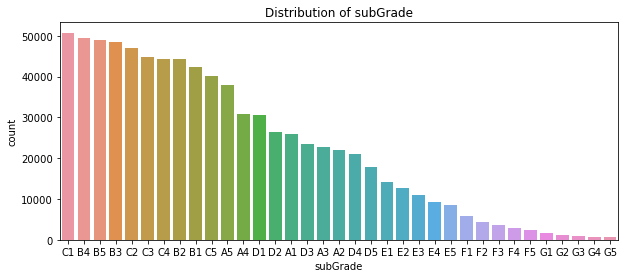

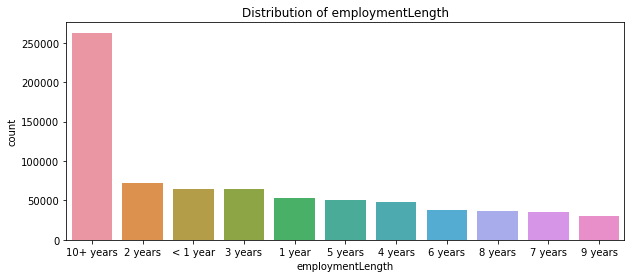

In [260]:
for col_name in ["grade", "subGrade", "employmentLength"]:
    plot_barchart(train[col_name], col_name, figsize=(10,4), 
              title="Distribution of %s" % col_name, save_path="assets/distribution/%s_dist.png" % col_name)

- term, verificationStatus, initialListStatus, applicationType, homeOwnership, purpose
    - "applicationType", 98% of data are 0, only 2% are 1
    - "homeOwnership": 89% of data are 0 or 1, 11% > 1 (group 2-5 together)

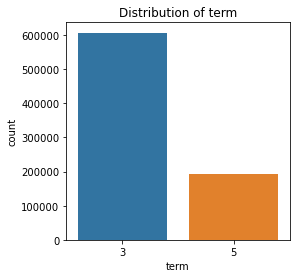

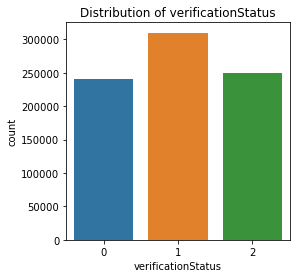

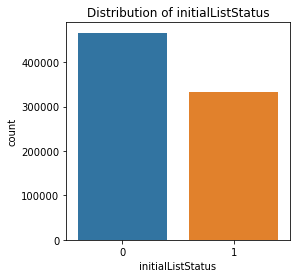

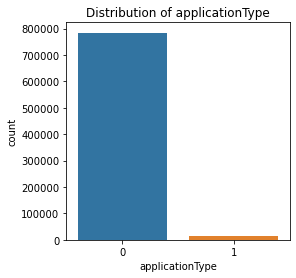

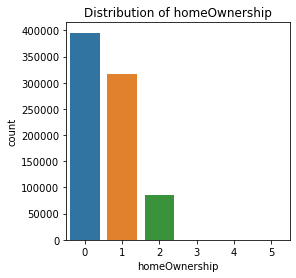

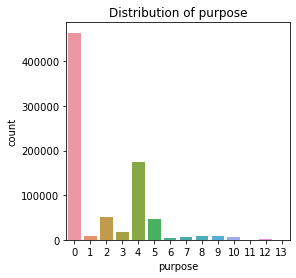

In [185]:
for col_name in ["term", "verificationStatus", "initialListStatus", "applicationType", "homeOwnership", "purpose"]:
    plot_barchart(train[col_name], col_name, figsize=(4,4),  
              title="Distribution of %s" % col_name, save_path="assets/distribution/%s_dist.png" % col_name)

In [186]:
train["applicationType"].value_counts()

0    784586
1     15414
Name: applicationType, dtype: int64

In [188]:
train["homeOwnership"].value_counts()

0    395732
1    317660
2     86309
3       185
5        81
4        33
Name: homeOwnership, dtype: int64

- issueDate and earliesCreditLine, count by year

In [ ]:
df = train["earliesCreditLine"].apply(lambda x: datetime.strptime(x, '%b-%Y').year)

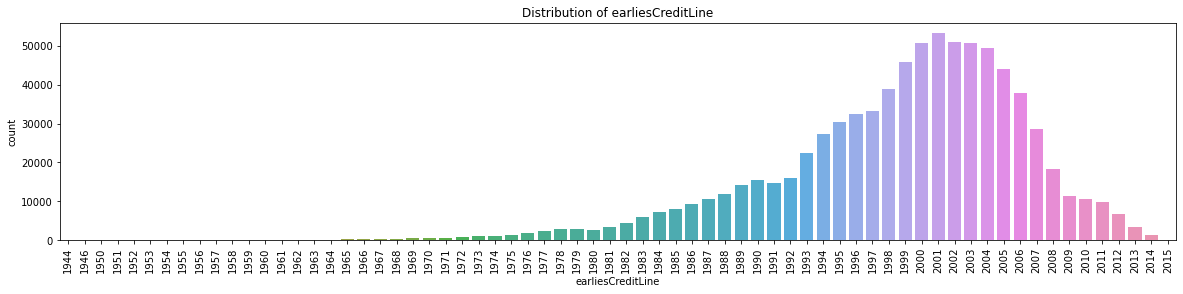

In [177]:
col_name = "earliesCreditLine"

plot_barchart(df, col_name, figsize=(20,4), rotation=90,
              title="Distribution of %s" % col_name, 
              save_path="assets/distribution/%s_dist.png" % col_name)

In [179]:
df = train["issueDate"].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').year)

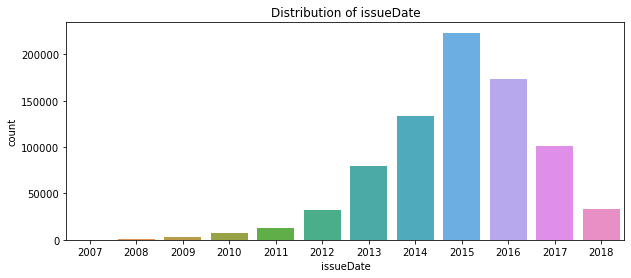

In [182]:
col_name = "issueDate"

plot_barchart(df, col_name, figsize=(10,4), rotation=0,
              title="Distribution of %s" % col_name, 
              save_path="assets/distribution/%s_dist.png" % col_name)

### Numeric feature distribution
- most numeric features are right-skewed (large outliers)

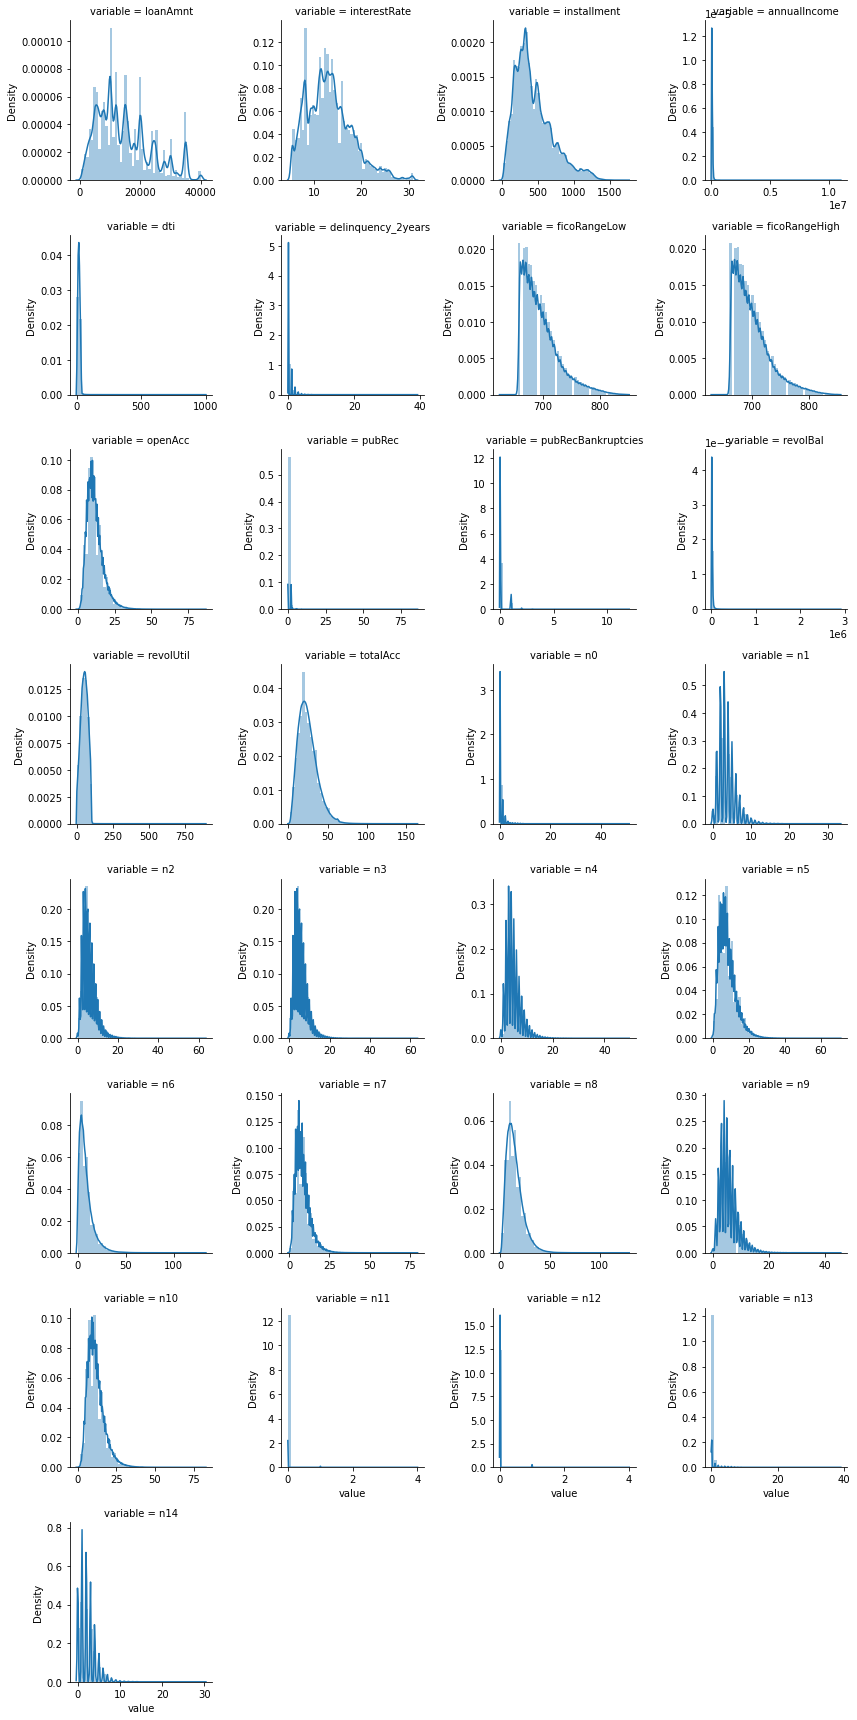

In [192]:
f = pd.melt(train, value_vars=numeric_conts_feat)
g = sns.FacetGrid(f, col="variable",  col_wrap=4, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")
g.figure.savefig("assets/distribution/num_dist.png")

- distribution after log-transformation
    - discretize: ficoRangeLow, ficoRangeHigh, annualIncome, dti, delinquency, some nx features
    - use log-transformation for the remaining features

In [208]:
def visual_log_transform(df, col_list, width=12, height=80, save_path=""):
    num_rows = len(col_list)
    num_cols = 2

    plt.figure(figsize=(width, height))
    
    for idx in range(1, num_rows+1):
        plt.subplot(num_rows, num_cols, 2 * idx - 1)
        sub_plot_1 = sns.distplot(df[col_list[idx - 1]])
        sub_plot_1.set_title("%s Distribuition" % col_list[idx - 1], fontsize=12)
        sub_plot_1.set_xlabel("")
        sub_plot_1.set_ylabel("Probability", fontsize=10)

        plt.subplot(num_rows, num_cols, 2 * idx )
        
        # avoid log of 0
        sub_plot_2 = sns.distplot(np.where(
            df[col_list[idx - 1]] != 0, 
            np.log(df[col_list[idx - 1]]), 0))
        
        sub_plot_2.set_title("%s (Log) Distribuition" % col_list[idx - 1], fontsize=12)
        sub_plot_2.set_xlabel("")
        sub_plot_2.set_ylabel("Probability", fontsize=10)
    
    if save_path:
        plt.savefig(save_path)

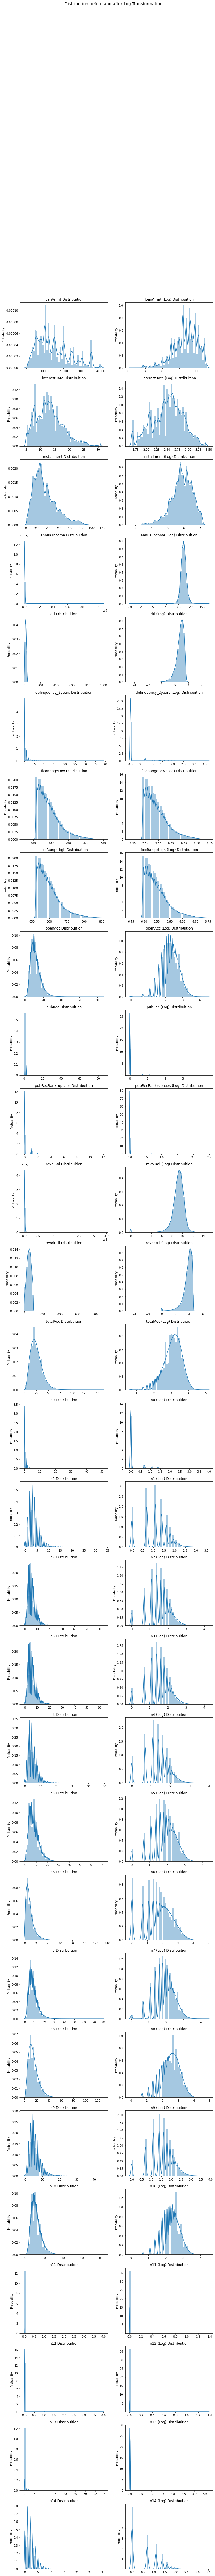

In [211]:
visual_log_transform(train, numeric_conts_feat, save_path="assets/distribution/num_log_dist.png")

## Check correlation between features and predicted label

### categorical features

In [226]:
def plot_default_rate(rate, col_name, label="isDefault", figsize=(6,4), title="", save_path="", rotation=0):
    
    plt.figure(figsize=figsize)
    sns.barplot(
        rate.keys(),
        rate,
    )
    
    plt.xlabel(col_name)
    if rotation:
        plt.xticks(rotation = 90)
    plt.ylabel("default rate")
    
    if title:
        plt.title(title)
        
    if save_path:
        plt.savefig(save_path)
        
    plt.show()

- "grade", "subGrade", "employmentLength"
    - employmentLength is not distinguishable

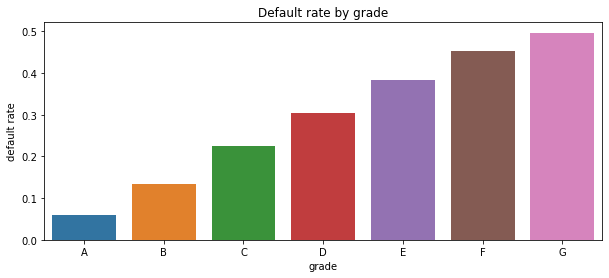

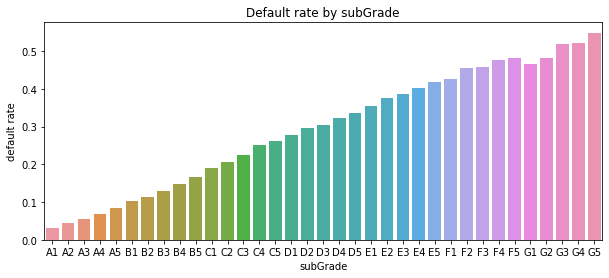

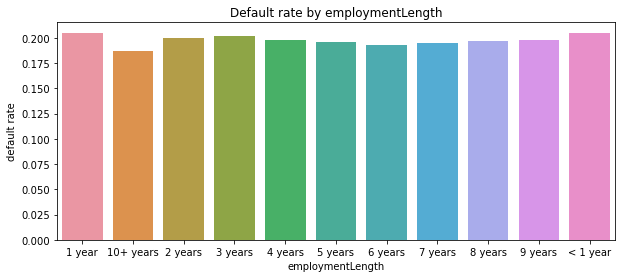

In [228]:
label = "isDefault"
for col_name in ["grade", "subGrade", "employmentLength"]:
    
    rate = train.groupby(col_name).apply(lambda x: x[label].sum() / x[label].count())
    
    plot_default_rate(rate, col_name, label="isDefault", figsize=(10,4), 
                      title="Default rate by %s" % col_name, 
                      save_path="assets/default_rate/%s.png" % col_name)

- "term", "verificationStatus", "initialListStatus", "applicationType", "homeOwnership", "purpose"
    - initialListStatus is not distinguishable

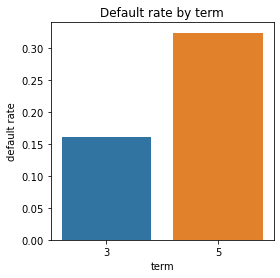

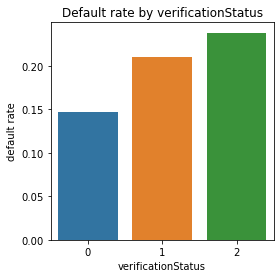

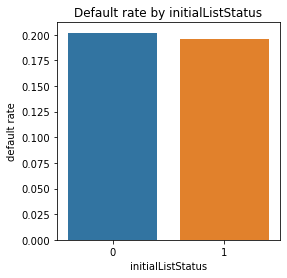

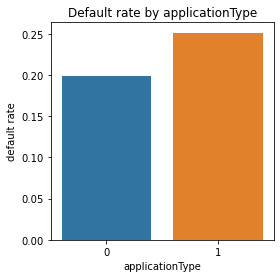

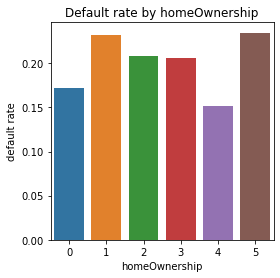

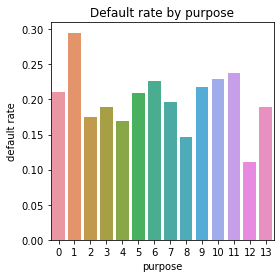

In [270]:
for col_name in ["term", "verificationStatus", "initialListStatus", "applicationType", "homeOwnership", "purpose"]:
    rate = train.groupby(col_name).apply(lambda x: x[label].sum() / x[label].count())
    
    plot_default_rate(rate, col_name, label="isDefault", figsize=(4,4), 
                      title="Default rate by %s" % col_name, 
                      save_path="assets/default_rate/%s.png" % col_name)

- difference between issueDate (year) and earliesCreditLine (year), reflect the number of years of credit the borrowers has been recorded
    - correlation: longer credit years -> lower default rate, but weak correlation

In [230]:
earliesCreditLine_year = train["earliesCreditLine"].apply(lambda x: datetime.strptime(x, '%b-%Y').year)

issueDate_year = train["issueDate"].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').year)

In [239]:
df = pd.DataFrame({"earliesCreditLine_year": earliesCreditLine_year, 
                   "issueDate_year": issueDate_year,
                   "isDefault": train["isDefault"]})

df["year_diff"] = df["issueDate_year"] - df["earliesCreditLine_year"]

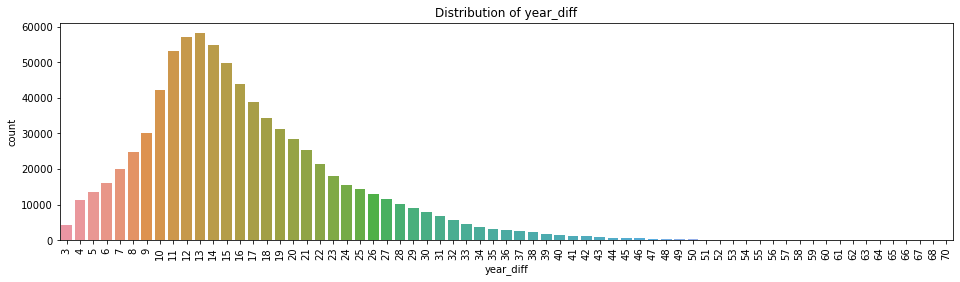

In [271]:
col_name = "year_diff"
plot_barchart(df["year_diff"], "year_diff", figsize=(16,4), rotation=90,
              title="Distribution of %s" % col_name, save_path="assets/distribution/%s_dist.png" % col_name)

The correlation between year_diff and default is -0.0322 


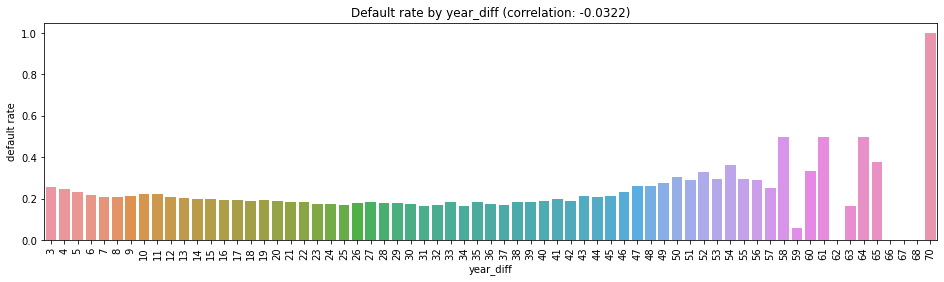

In [272]:
col_name = "year_diff"
rate = df.groupby("year_diff").apply(lambda x: x[label].sum() / x[label].count())
corr = np.corrcoef(df["year_diff"], df["isDefault"])[0][1]
print("The correlation between year_diff and default is %.4f " % corr)

plot_default_rate(rate, "year_diff", label="isDefault", figsize=(16,4), rotation=90,
                  title="Default rate by %s (correlation: %.4f)" % (col_name, corr),
                  save_path="assets/default_rate/%s.png" % col_name)

## Numeric features

- correlation matrix: the first column is the correlation between each numeric feature and the label
    - all correlation between feat and label are weak, except for interestRate, dti, fico, revolUtil, n9 and n14
    - the correlation between some groups of numeric features are very high
        - n1-n10, openAcc, revoBal and totalAcc
        ficoRangeLow and fociRangeHigh

In [273]:
corr_matrix = train[["isDefault"] + numeric_conts_feat].corr()

In [302]:
def plot_corr_heatmap(corr, figsize=(10,6), save_path=""):
    plt.figure(figsize=figsize)
    mask = np.triu(np.ones_like(corr, dtype=np.bool))
    heatmap = sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, annot=False, cmap="RdBu_r")
    heatmap.set_title('Correlation Heatmap between Numeric Features and isDefault', 
                      fontdict={'fontsize':12}, pad=16)
    
    if save_path:
        heatmap.figure.savefig(save_path)

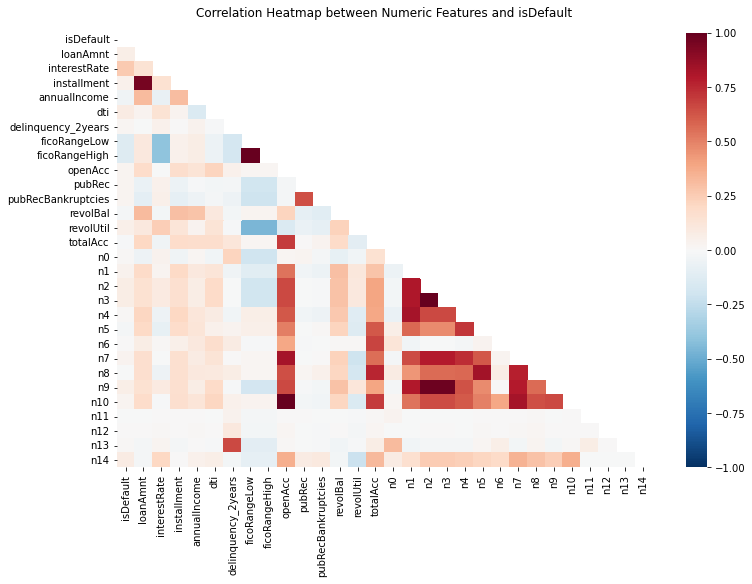

In [303]:
plot_corr_heatmap(corr_matrix, figsize=(12,8), save_path="assets/corr_heatmap.png")

- difference of distribution between default and non-default numeric features

In [348]:
def visual_default_dist(df, col_list, width=12, height=6, bins=50, save_path=""):
    num_rows = len(col_list)
    num_cols = 2

    plt.figure(figsize=(width, height))
    
    for idx in range(num_rows):
        plt.subplot(math.ceil(num_rows / 2), num_cols, idx + 1)
        sns.histplot(df, x=col_list[idx], hue="isDefault", bins=bins,
             kde=False, stat='density', element="step", common_norm=False)
    
    if save_path:
        plt.savefig(save_path)

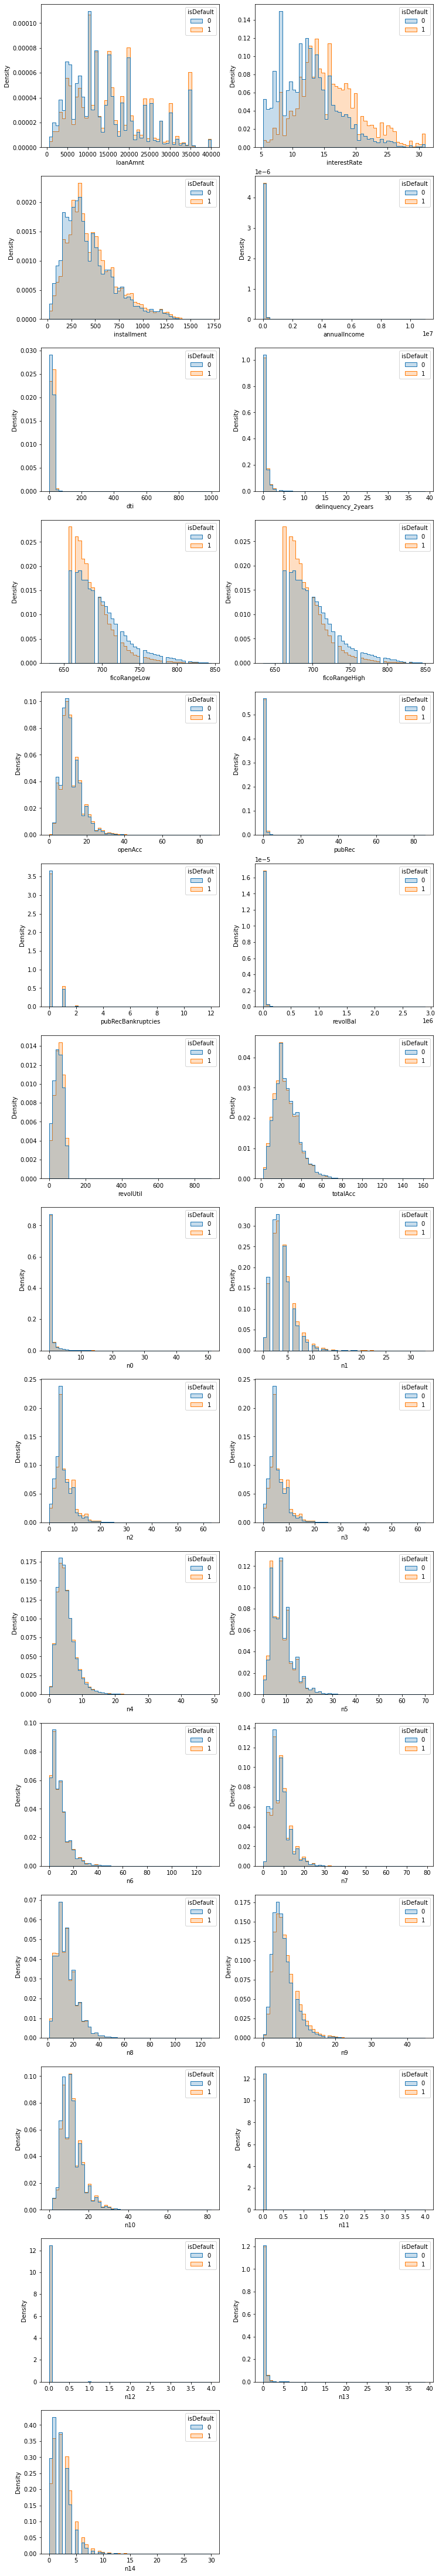

In [350]:
visual_default_dist(train, numeric_conts_feat, width=12, height=80, 
                    save_path="assets/num_dist_by_default.png")